In [1]:
import pandas as pd
import numpy as np
import json, os
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import glob
import warnings

C:\Users\t3q_dhkim\anaconda3\envs\intern\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\t3q_dhkim\anaconda3\envs\intern\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\t3q_dhkim\anaconda3\envs\intern\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [70]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

#pd.Series([1, 3, 5, -7, 9]).plot(title="한글")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

## 2. 텍스트 분류 실습

### 2.1 데이터 미리보기

In [3]:
df_sample = pd.read_json('022.요약문 및 레포트 생성 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL1\\01.news_r\\20per\\REPORT-news_r-00001-00001.json')
df_sample

,Meta(Acqusition),Meta(Refine),Annotation
doc_id,REPORT-news_r-00001,NaN,NaN
doc_category,REPORT,NaN,NaN
doc_type,news_r,NaN,NaN
doc_name,"40억달러 딜 주인공 김봉진 ""국내서 폼잡다 죽고싶지 않았다""",NaN,NaN
author,김선영,NaN,NaN
publisher,중앙일보,NaN,NaN
publisher_year,2020,NaN,NaN
doc_origin,중앙일보,NaN,NaN
passage_id,NaN,REPORT-news_r-00001-00001,NaN
passage,NaN,40억 달러 ‘딜’ 주인공 김봉진 우아한형제들 대표태풍 뒤의 고요함이랄까.\n 4...,NaN


* 메타 정보(수집 단계), 메타 정보(정제 단계), 요약문으로 나뉘어져있다. 
* 문서 유형 (doc_type), 문서명 (doc_name), 원문 (passage), 원문 글자수 (passage_Cnt) 을 제외한 정보는 제거한다.
* 원문 텍스트만으로 어떤 문서 유형에 속하는지 확인한다.

### 2.2 데이터 병합

각 다른 문서 유형의 폴더 안에 있는 파일들을 한 곳으로 모은다. 여기서는 빠른 계산을 위해 1.0 Training 학습 데이터셋에서 유형별로 100개의 파일을 추출한다.

In [4]:
# 1.0 Training 학습세트에서 100개씩 추출
folders = [
    '01.news_r',
    '02.briefing',
    '03.his_cul',
    '04.paper',
    '05.minute',
    '06.edit',
    '07.public',
    '08.speech',
    '09.literature',
    '10.narration'
    
]

file_limit = 100
file_paths = []

for folder in folders:
    folder_path = f'022.요약문 및 레포트 생성 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL1\\{folder}\\2~3sent\\*.json'
    files = glob.glob(folder_path)[:file_limit]
    file_paths.extend(files)

# Print the resulting file paths
#for file_path in file_paths:
#    print(file_path)
len(file_paths)
#file_paths[:4]

1000

In [5]:
%%time 
# Initialize an empty DataFrame
df = pd.DataFrame(columns=[ "doc_type", "doc_name", "author", "publisher", "passage", "passage_id"])

# Iterate over each JSON file
for file_path in file_paths:
    # Load the JSON file
    with open(file_path, "r", encoding="utf-8") as file:
        json_data = json.load(file)
    
    # Extract the required information
    doc_type = json_data["Meta(Acqusition)"]["doc_type"]
    doc_name = json_data["Meta(Acqusition)"]["doc_name"]
    #passage_Cnt = json_data["Meta(Refine)"]["passage_Cnt"]
    passage = json_data["Meta(Refine)"]["passage"]
    passage_id = json_data["Meta(Refine)"]["passage_id"]
    author = json_data["Meta(Acqusition)"]["author"]
    publisher = json_data["Meta(Acqusition)"]["publisher"]

    # Append a new row to the DataFrame
    #train_data = train_data.append({"doc_type": doc_type, "doc_name": doc_name, "passage_Cnt": passage_Cnt, "passage": passage}, ignore_index=True)
    df.loc[len(df)] = [doc_type,doc_name, author, publisher, passage,passage_id]
    
# Print the resulting DataFrame
print(df.shape)
df

(1000, 6)
CPU times: total: 859 ms
Wall time: 911 ms


,doc_type,doc_name,author,publisher,passage,passage_id
0,news_r,"[최상연 논설위원이 간다] 이재오 “무반성 한국당, 무능 지도부…이대론 총선 어렵다”",김선영,중앙일보,보수진영 사분오열 속 ‘국민통합연대’ 띄운 비박계 크리스마스를 앞둔 지난 23일 오...,REPORT-news_r-00007-00001
1,news_r,"26세에 14억 빚 얻은 청년, 8년만에 연매출 183억 비결은?",이수기,중앙일보,가난 속에서 맨손으로 혼자 창업해 30대 중반에 코스닥 상장까지 일궈낸 이가 있다....,REPORT-news_r-00018-00001
2,news_r,"이통사 장기 가입자 혜택 비교해 보니…VIP일까, 호갱일까",박형수,중앙일보,"SK텔레콤은 ‘T끼리 온가족 할인’ 요금제로, 가족 구성원의 가입 합산 기간이...",REPORT-news_r-00020-00002
3,news_r,자율포장 테이프 없애놓고 1+1 상품엔 둘둘···대형마트의 모순,천권필,중앙일보,“박스 테이프는 어디 갔죠?” 1일 오전 서울 중구의 한 대형마트.\n 장을 본 ...,REPORT-news_r-00024-00001
4,news_r,"이달 출시 제네시스 첫 SUV 살짝 공개···전문가들 ""예상대로""",김영주,중앙일보,"현대차그룹 고급 브랜드 제네시스의 첫 스포츠유틸리티차량(SUV), GV80이 드디어...",REPORT-news_r-00029-00001
...,...,...,...,...,...,...
995,narration,51006_DC_걸어서세계속으로006_2014007630.txt,KBS,KBS,한국과는 정반대다.\n계절의 뒤바뀜을 느껴보는 것도 여행의 또 다른 재미다.\n이곳...,REPORT-narration-51006-00019
996,narration,51007_DC_걸어서세계속으로007_2014007672.txt,KBS,KBS,1960년대부터는 중국의 박해를 피해 망명한 티베트인들이 이곳을 중심으로 네팔에 정...,REPORT-narration-51007-00003
997,narration,51007_DC_걸어서세계속으로007_2014007672.txt,KBS,KBS,포카라에서는 어느 곳에서나 안나푸르나 산 문을 볼 수 있다.\n안나푸르나로 가는 길...,REPORT-narration-51007-00004
998,narration,51007_DC_걸어서세계속으로007_2014007672.txt,KBS,KBS,청년의 친절이 고마웠다.\n주민들은 산비탈을 깎아 만든 계단식 밭에서 겨울에는 주로...,REPORT-narration-51007-00007


In [6]:
df["author"].value_counts()

author
KBS    100
김선영     25
채만식     20
김동인     12
이효석     10
      ... 
천권필      1
박태인      1
유지연      1
하선영      1
김효성      1
Name: count, Length: 79, dtype: int64

In [7]:
df["publisher"].value_counts()

publisher
중앙일보    100
KBS     100
Name: count, dtype: int64

In [8]:
df.isnull().sum()

doc_type        0
doc_name        0
author        700
publisher     800
passage         0
passage_id      0
dtype: int64

In [9]:
# 2.0 Validation 검증용 세트
vfolders = [
    '01.news_r',
    '02.briefing',
    '03.his_cul',
    '04.paper',
    '05.minute',
    '06.edit',
    '07.public',
    '08.speech',
    '09.literature',
    '10.narration'
    
]
vfile_limit = 15
vfile_paths = []

for folder in vfolders:
    folder_path = f'022.요약문 및 레포트 생성 데이터\\01.데이터\\2.Validation\\라벨링데이터\\VL1\\{folder}\\2~3sent\\*.json'
    files = glob.glob(folder_path)[:vfile_limit]
    vfile_paths.extend(files)

# Print the resulting file paths
#for file_path in file_paths:
#    print(file_path)
len(vfile_paths)

150

In [10]:
%%time 
# Initialize an empty DataFrame
dft= pd.DataFrame(columns=[ "doc_type", "doc_name", "author", "publisher", "passage", "passage_id"])

# Iterate over each JSON file
#print(file_paths)
for file_path in vfile_paths:
    # Load the JSON file
    with open(file_path, "r", encoding="utf-8") as file:
        json_data = json.load(file)
    
    # Extract the required information
    doc_type = json_data["Meta(Acqusition)"]["doc_type"]
    doc_name = json_data["Meta(Acqusition)"]["doc_name"]
    passage_id = json_data["Meta(Refine)"]["passage_id"]
    passage = json_data["Meta(Refine)"]["passage"]

     # Create a new DataFrame for the current row
    #dft = pd.DataFrame({"doc_type": [doc_type],"passage": [passage]})
    dft.loc[len(dft)] = [doc_type,doc_name, author, publisher, passage,passage_id]
    # Append the new DataFrame to the list
    #dft.append(dft)

# Concatenate all DataFrames into a single DataFrame#
#valid_data = pd.concat(dft, ignore_index=True)
# Print the resulting DataFrame
print(dft.shape)
dft.head()

(150, 6)
CPU times: total: 93.8 ms
Wall time: 124 ms


,doc_type,doc_name,author,publisher,passage,passage_id
0,news_r,[마음 읽기] 새해의 첫 마음,KBS,KBS,새해가 밝았다.\n 또 다른 한 해가 시작되었다.\n 눈이 내린 하얀 설원이 앞...,REPORT-news_r-00003-00001
1,news_r,"'남의 팔 가진 사나이' 3년의 행복···""8월엔 아빠 됩니다""",KBS,KBS,"""기다리던 새해가 밝았네요.\n 올해 제가 드디어 아빠가 됩니다.\n "" 국내에서...",REPORT-news_r-00015-00001
2,news_r,"새 전략무기 언급한 김정은···""조만간 전략잠수함 진수식 첩보""",KBS,KBS,김정은 국무위원장이 지난달 28일부터 31일까지 열린 노동당 중앙위원회 전원회의 ...,REPORT-news_r-00028-00001
3,news_r,“경선 밀리신거냐” 그 말에···예비후보 벌써 등록한 현역 8명,KBS,KBS,"신 의원은 ""총선에 제가 다시 도전한다는 의사표시로 예비후보를 등록했다""고 말했다...",REPORT-news_r-00032-00002
4,news_r,"손등에 칩 심고 결제하는 나라 스웨덴, 돌연 ""현금 지키자"" 왜",KBS,KBS,스웨덴에서는 지갑을 몸에 지니지 않아도 일상생활에 불편을 겪지 않는 이들이 있다.\...,REPORT-news_r-00058-00001


### 2.3 전처리

In [11]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

#### 2.3.1 데이터 정제

In [12]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\n', ' ', text)
    #text = re.sub('‘', '', text)
    #text = re.sub('’', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub(' +', ' ', text)
    return text

In [16]:
%time df['content_preprocessing'] = df['passage'].apply(preprocessing)

CPU times: total: 31.2 ms
Wall time: 75.7 ms


#### 2.3.2. 불용어 제거

In [14]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', 
             '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', 
             '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', 
             '왜','같은', '같습니다', '없습니다', '위해', '한다', 
             '여명', '이다', '에', '고', '란', '는', '그래도', '개에', '개인데', '일엔']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [19]:
%time df['content_preprocessed'] = df['content_preprocessing'].apply(remove_stopwords)
df.head()

CPU times: total: 31.2 ms
Wall time: 81.8 ms


,doc_type,doc_name,author,publisher,passage,passage_id,content_preprocessing,content_preprocessed
0,news_r,"[최상연 논설위원이 간다] 이재오 “무반성 한국당, 무능 지도부…이대론 총선 어렵다”",김선영,중앙일보,보수진영 사분오열 속 ‘국민통합연대’ 띄운 비박계 크리스마스를 앞둔 지난 23일 오...,REPORT-news_r-00007-00001,보수진영 사분오열 속 국민통합연대 띄운 비박계 크리스마스를 앞둔 지난 일 오전 서울...,보수진영 사분오열 속 국민통합연대 띄운 비박계 크리스마스를 앞둔 지난 오전 서울 프...
1,news_r,"26세에 14억 빚 얻은 청년, 8년만에 연매출 183억 비결은?",이수기,중앙일보,가난 속에서 맨손으로 혼자 창업해 30대 중반에 코스닥 상장까지 일궈낸 이가 있다....,REPORT-news_r-00018-00001,가난 속에서 맨손으로 혼자 창업해 대 중반에 코스닥 상장까지 일궈낸 이가 있다 지난...,가난 속에서 맨손으로 혼자 창업해 대 중반에 코스닥 상장까지 일궈낸 이가 있다 지난...
2,news_r,"이통사 장기 가입자 혜택 비교해 보니…VIP일까, 호갱일까",박형수,중앙일보,"SK텔레콤은 ‘T끼리 온가족 할인’ 요금제로, 가족 구성원의 가입 합산 기간이...",REPORT-news_r-00020-00002,SK텔레콤은 T끼리 온가족 할인 요금제로 가족 구성원의 가입 합산 기간이 년을 넘...,SK텔레콤은 T끼리 온가족 할인 요금제로 가족 구성원의 가입 합산 기간이 년을 넘...
3,news_r,자율포장 테이프 없애놓고 1+1 상품엔 둘둘···대형마트의 모순,천권필,중앙일보,“박스 테이프는 어디 갔죠?” 1일 오전 서울 중구의 한 대형마트.\n 장을 본 ...,REPORT-news_r-00024-00001,박스 테이프는 어디 갔죠 일 오전 서울 중구의 한 대형마트 장을 본 사람들이 자율...,박스 테이프는 어디 갔죠 오전 서울 중구의 대형마트 장을 본 사람들이 자율포장대 ...
4,news_r,"이달 출시 제네시스 첫 SUV 살짝 공개···전문가들 ""예상대로""",김영주,중앙일보,"현대차그룹 고급 브랜드 제네시스의 첫 스포츠유틸리티차량(SUV), GV80이 드디어...",REPORT-news_r-00029-00001,현대차그룹 고급 브랜드 제네시스의 첫 스포츠유틸리티차량 SUV GV 이 드디어 모습...,현대차그룹 고급 브랜드 제네시스의 첫 스포츠유틸리티차량 SUV GV 이 드디어 모습...


In [20]:
##validation
%time dft['content_preprocessing'] = dft['passage'].apply(preprocessing)
%time dft['content_preprocessed'] = dft['content_preprocessing'].apply(remove_stopwords)

CPU times: total: 0 ns
Wall time: 10.8 ms
CPU times: total: 0 ns
Wall time: 10.1 ms


In [21]:
#df_valid = valid_data.drop(columns=['passage', 'content_preprocessing'])
dft.head()

,doc_type,doc_name,author,publisher,passage,passage_id,content_preprocessing,content_preprocessed
0,news_r,[마음 읽기] 새해의 첫 마음,KBS,KBS,새해가 밝았다.\n 또 다른 한 해가 시작되었다.\n 눈이 내린 하얀 설원이 앞...,REPORT-news_r-00003-00001,새해가 밝았다 또 다른 한 해가 시작되었다 눈이 내린 하얀 설원이 앞에 펼쳐져 있는...,새해가 밝았다 또 다른 해가 시작되었다 눈이 내린 하얀 설원이 앞에 펼쳐져 느낌이다...
1,news_r,"'남의 팔 가진 사나이' 3년의 행복···""8월엔 아빠 됩니다""",KBS,KBS,"""기다리던 새해가 밝았네요.\n 올해 제가 드디어 아빠가 됩니다.\n "" 국내에서...",REPORT-news_r-00015-00001,기다리던 새해가 밝았네요 올해 제가 드디어 아빠가 됩니다 국내에서 처음으로 남의 ...,기다리던 새해가 밝았네요 올해 제가 드디어 아빠가 됩니다 국내에서 처음으로 남의 ...
2,news_r,"새 전략무기 언급한 김정은···""조만간 전략잠수함 진수식 첩보""",KBS,KBS,김정은 국무위원장이 지난달 28일부터 31일까지 열린 노동당 중앙위원회 전원회의 ...,REPORT-news_r-00028-00001,김정은 국무위원장이 지난달 일부터 일까지 열린 노동당 중앙위원회 전원회의 보고에서...,김정은 국무위원장이 지난달 일부터 일까지 열린 노동당 중앙위원회 전원회의 보고에서...
3,news_r,“경선 밀리신거냐” 그 말에···예비후보 벌써 등록한 현역 8명,KBS,KBS,"신 의원은 ""총선에 제가 다시 도전한다는 의사표시로 예비후보를 등록했다""고 말했다...",REPORT-news_r-00032-00002,신 의원은 총선에 제가 다시 도전한다는 의사표시로 예비후보를 등록했다 고 말했다 ...,신 의원은 총선에 제가 다시 도전한다는 의사표시로 예비후보를 등록했다 말했다 다른...
4,news_r,"손등에 칩 심고 결제하는 나라 스웨덴, 돌연 ""현금 지키자"" 왜",KBS,KBS,스웨덴에서는 지갑을 몸에 지니지 않아도 일상생활에 불편을 겪지 않는 이들이 있다.\...,REPORT-news_r-00058-00001,스웨덴에서는 지갑을 몸에 지니지 않아도 일상생활에 불편을 겪지 않는 이들이 있다 엄...,스웨덴에서는 지갑을 몸에 지니지 않아도 일상생활에 불편을 겪지 않는 이들이 있다 엄...


#### 2.3.3 문장 분리

In [ ]:
import kss


In [ ]:
df['content_preprocessed']

In [ ]:
sents=[]
for sent in df['content_preprocessed'][:3]:
    sent = sent.strip()
    if sent:
        splited_sentence = kss.split_sentences(sent)
        sents.extend(splited_sentence)
    
sents

### 2.4 TF-IDF Vectorizing

* 데이터에 대해 TF-IDF 값으로 벡터화를 진행한다.
* min_df : 설정한 값보다 특정 Token의 df 값이 더 적게 나오면 벡터화 과정에서 제거
* anlayzer : 분석 단위를 의미, ‘word’의 경우 간어 하나를 단위로, ‘char’는 문자 하나를 단위로
* sublinear_tf : 문서의 단어 빈도수(tf:term frequency)에 대한 smoothing 여부를 설정
* ngram_range : 빈도의 기본 단위를 어떤 범위의 n-gram으로 설정할 것인지를 보는 인자
* max_features : 각 벡터의 최대 길이(특징의 길이)를 설정

#### 2.4 학습, 시험 데이터 세트 분리

학습 데이터 세트와 시험 데이터 세트로 다시 분리한다. 정닶값인 doc_type 값 여부에 따라 데이터를 나눌 수 있다.

In [22]:
#데이터를 나누는 기준을 구함
split_count = int(df.shape[0]*0.7)
split_count

700

In [64]:
# Shuffle the data randomly
shuffled_df = df.sample(frac=1, random_state=42)
shuffled_dft = dft.sample(frac=1, random_state=42)
shuffled_df.head()
shuffled_dft.head()

,doc_type,doc_name,author,publisher,passage,passage_id,content_preprocessing,content_preprocessed
73,minute,제19대 국회 교육과학기술위원회 회의록 데이터셋_16481.csv,KBS,KBS,"위원장 신학용] ""수고하셨습니다. 유기홍 위원님 마지막 질의해 주시기 바랍니다....",REPORT-minute-00001-00856,위원장 신학용 수고하셨습니다 유기홍 위원님 마지막 질의해 주시기 바랍니다 유기홍 위...,위원장 신학용 수고하셨습니다 유기홍 위원님 마지막 질의해 주시기 바랍니다 유기홍 위...
18,briefing,(보도자료) 대형특수소방차 여성 기관원 증가.hwp,KBS,KBS,소방청(청장 정문호)은 전국적으로 48명의 여성 소방공무원이 대형특수소방차 운전요...,REPORT-briefing-51310-00001,소방청 청장 정문호 은 전국적으로 명의 여성 소방공무원이 대형특수소방차 운전요원으...,소방청 청장 정문호 은 전국적으로 명의 여성 소방공무원이 대형특수소방차 운전요원으...
118,speech,속기자료 13쪽 (2).hwp,KBS,KBS,<강성천 중소벤처기업부 차관> 중소벤처기업부 차관입니다. 바이오 산업은 4차 산업의...,REPORT-speech-00094-00001,강성천 중소벤처기업부 차관 중소벤처기업부 차관입니다 바이오 산업은 차 산업의 가장...,강성천 중소벤처기업부 차관 중소벤처기업부 차관입니다 바이오 산업은 차 산업의 가장...
78,edit,"【서봉대의 ‘되짚기’】 대선 후보경선, 결선까지 갈까? 역전 가능성은...",KBS,KBS,이번 대선에서 결선투표가 이뤄질 수 있을까? 결선투표를 대선 본선에서 실시하는 건 ...,REPORT-edit-00028-00001,이번 대선에서 결선투표가 이뤄질 수 있을까 결선투표를 대선 본선에서 실시하는 건 개...,이번 대선에서 결선투표가 이뤄질 있을까 결선투표를 대선 본선에서 실시하는 건 개헌사...
76,edit,【이상곤의 ‘흐름’】 윤석열 검찰의 고발사주 의혹? “이번에도 작전 들어갔나”,KBS,KBS,이번에는 윤석열 검찰이 작년 총선을 코앞에 두고 유시민과 최강욱.이번엔 비교적 신생...,REPORT-edit-00020-00002,이번에는 윤석열 검찰이 작년 총선을 코앞에 두고 유시민과 최강욱 이번엔 비교적 신생...,이번에는 윤석열 검찰이 작년 총선을 코앞에 두고 유시민과 최강욱 이번엔 비교적 신생...


In [24]:
#학습세트 만들기
df_train = shuffled_df[:split_count].copy()
df_train.shape
#df_train.head()

(700, 8)

In [25]:
df_test = shuffled_df[split_count:].copy()
df_test.shape

(300, 8)

In [65]:
dft_valid = shuffled_dft[:300].copy()
dft_valid.shape

(150, 8)

In [26]:
y_train = df_train["doc_type"]
y_train.value_counts()

doc_type
news_r        76
narration     76
edit          75
briefing      73
paper         73
his_cul       69
minute        68
public        67
literature    62
speech        61
Name: count, dtype: int64

In [27]:
y_test = df_test["doc_type"]
y_test.value_counts()

doc_type
speech        39
literature    38
public        33
minute        32
his_cul       31
briefing      27
paper         27
edit          25
narration     24
news_r        24
Name: count, dtype: int64

#### 단어 벡터화 하기

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             min_df = 2, 
                             ngram_range=(1, 3),
                             max_features = 1500
                            )
vectorizer

In [ ]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessed'])
train_feature_vector.shape

In [ ]:
%%time 
test_feature_vector = vectorizer.transform(df_test['content_preprocessed'])
test_feature_vector.shape

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(len(vocab))
vocab[:10]

In [ ]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

#### TF-IDF 가중치 적용

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

In [ ]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

In [ ]:
%%time 
test_feature_tfidf = transformer.transform(test_feature_vector)
test_feature_tfidf.shape

In [ ]:
test_feature_tfidf.shape

### TF-IDF 를 활용한 모델 구현

In [73]:
X_train = df_train["content_preprocessed"]
X_test = df_test["content_preprocessed"]
X_train.shape, X_test.shape

((700,), (300,))

In [63]:
X_valid = dft['content_preprocessed']
X_valid.head()

0    새해가 밝았다 또 다른 해가 시작되었다 눈이 내린 하얀 설원이 앞에 펼쳐져 느낌이다...
1     기다리던 새해가 밝았네요 올해 제가 드디어 아빠가 됩니다 국내에서 처음으로 남의 ...
2     김정은 국무위원장이 지난달 일부터 일까지 열린 노동당 중앙위원회 전원회의 보고에서...
3     신 의원은 총선에 제가 다시 도전한다는 의사표시로 예비후보를 등록했다 말했다 다른...
4    스웨덴에서는 지갑을 몸에 지니지 않아도 일상생활에 불편을 겪지 않는 이들이 있다 엄...
Name: content_preprocessed, dtype: object

In [67]:
y_valid = dft['doc_type']
y_valid.value_counts()

doc_type
news_r        15
briefing      15
his_cul       15
paper         15
minute        15
edit          15
public        15
speech        15
literature    15
narration     15
Name: count, dtype: int64

In [32]:
y_train = df_train["doc_type"]
y_train.value_counts()

doc_type
news_r        76
narration     76
edit          75
briefing      73
paper         73
his_cul       69
minute        68
public        67
literature    62
speech        61
Name: count, dtype: int64

In [33]:
y_test = df_test["doc_type"]
y_test.value_counts()

doc_type
speech        39
literature    38
public        33
minute        32
his_cul       31
briefing      27
paper         27
edit          25
narration     24
news_r        24
Name: count, dtype: int64

In [66]:
X_valid = dft_valid["content_preprocessed"]
X_valid.shape

(150,)

#### 벡터화
TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=None, 
                             ngram_range=(1,2),
                             min_df=3, 
                             max_df=0.95)
tfidf_vect.fit(X_train)

TfidfVectorizer(max_df=0.95, min_df=3, ngram_range=(1, 2))

In [35]:
train_feature_tfidf = tfidf_vect.transform(X_train)
test_feature_tfidf = tfidf_vect.transform(X_test)

train_feature_tfidf.shape, test_feature_tfidf.shape

((700, 6539), (300, 6539))

In [36]:
# 단어 사전
vocab = tfidf_vect.get_feature_names_out()
print(len(vocab))
vocab[:10]

6539


array(['ai', 'a씨는', 'ceo', 'cm', 'credit', 'dj', 'djp', 'dj가', 'dj와',
       'esg'], dtype=object)

In [37]:
# np.sum 으로 위에서 구한 train_feature_vector 의 값을 모두 더한다. axis=0 으로 한다. 
dist = np.sum(train_feature_tfidf, axis=0)

vocab_count = pd.DataFrame(dist, columns=vocab)
vocab_count

,ai,a씨는,ceo,cm,credit,dj,djp,dj가,dj와,esg,...,흔히,희망과,희망을,희망의,힘든,힘들다,힘써,힘을,힘이,힘입어
0,1.205585,0.391014,0.26862,0.916047,0.401786,1.408173,0.418229,0.458221,0.750045,1.378943,...,0.775533,0.394498,0.431539,0.344125,1.161799,0.251797,0.337629,1.332905,0.575747,0.349876


In [38]:
vocab_count.T[0]

ai        1.205585
a씨는       0.391014
ceo       0.268620
cm        0.916047
credit    0.401786
            ...   
힘들다       0.251797
힘써        0.337629
힘을        1.332905
힘이        0.575747
힘입어       0.349876
Name: 0, Length: 6539, dtype: float64

<Axes: >

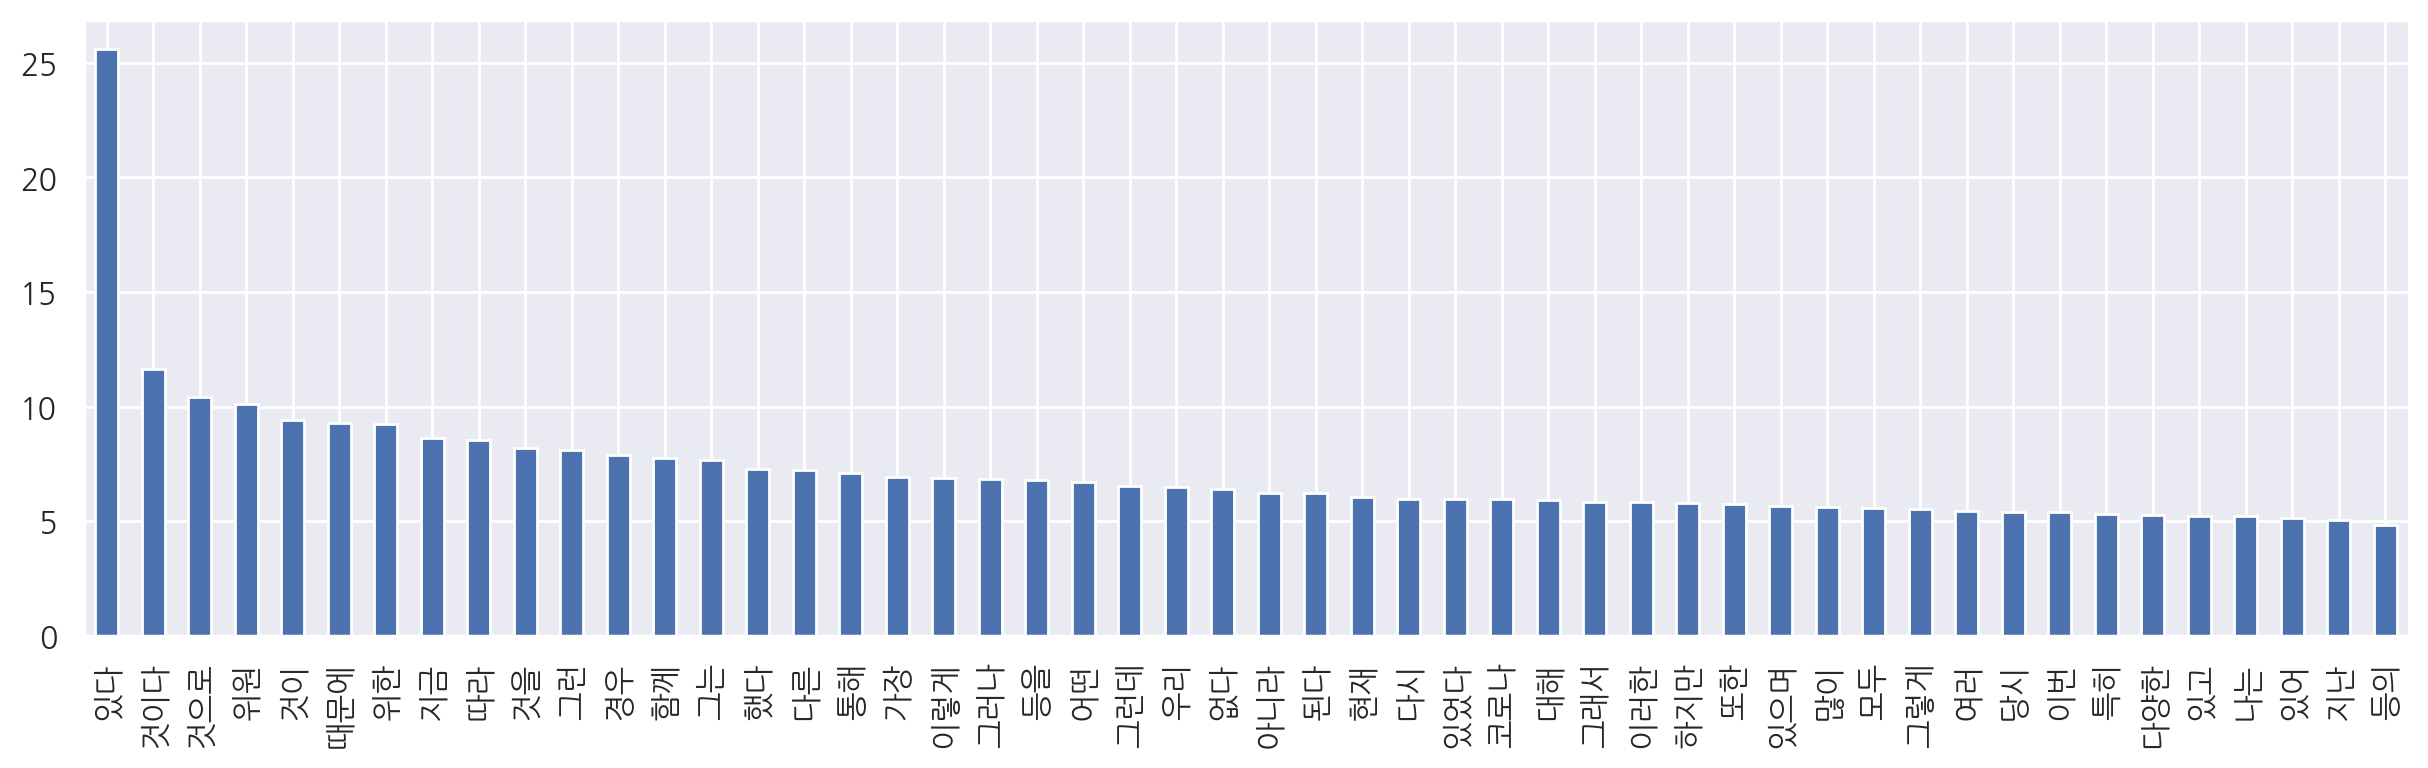

In [71]:
# 위에서 구한 빈도수를 그래프로 그린다.
vocab_count.T[0].sort_values(ascending=False).head(50).plot.bar(figsize=(15, 4))

#### 학습과 예측

In [46]:
# RandomForestClassifier 를 불러온다.
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=42)
model

RandomForestClassifier(n_jobs=-1, random_state=42)

In [47]:
# 학습에 사용할 y_label 을 넣어준다.
y_label = df_train['doc_type']
%time model = model.fit(train_feature_tfidf, y_label)

CPU times: total: 46.9 ms
Wall time: 134 ms


In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = 'accuracy'
score = cross_val_score(model, train_feature_tfidf, 
                        y_label, cv=k_fold, n_jobs=-1, 
                        scoring=scoring)
score

array([0.8       , 0.80714286, 0.78571429, 0.83571429, 0.85      ])

In [49]:
round(np.mean(score)*100,2)

81.57

In [50]:
y_pred = model.predict(test_feature_tfidf)
y_pred[:10]

array(['speech', 'public', 'literature', 'edit', 'literature', 'minute',
       'briefing', 'briefing', 'narration', 'narration'], dtype=object)

In [51]:
y_pred.shape

(300,)

#### 교차 검증

In [41]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, train_feature_tfidf, y_train, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


In [42]:
valid_accuracy = (y_pred == y_train).mean()
valid_accuracy

0.8028571428571428

In [43]:
df_accuracy = pd.DataFrame({"pred": y_pred, "train": y_train})
df_accuracy["accuracy"] = (y_pred == y_train)

In [44]:
doc_type

'narration'

In [ ]:
passage = list(df_train['content_preprocessed'])
doctype = list(df_train['doc_type'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char', sublinear_tf = True, ngram_range=(1,3),max_features=5000)
X = vectorizer.fit_transform(passage)

### Random Forest Tree classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train['content_preprocessed'], df_train['doc_type'], test_size=0.3, random_state=42)

In [68]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_valid_vectorized = vectorizer.transform(X_valid)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_valid_vectorized)

# Evaluate the classifier
classification_report = classification_report(y_valid, y_pred)
print(classification_report)

              precision    recall  f1-score   support

    briefing       0.17      0.07      0.10        15
        edit       0.15      0.13      0.14        15
     his_cul       0.09      0.13      0.11        15
  literature       0.15      0.13      0.14        15
      minute       0.11      0.13      0.12        15
   narration       0.17      0.27      0.21        15
      news_r       0.14      0.13      0.14        15
       paper       0.11      0.13      0.12        15
      public       0.09      0.07      0.08        15
      speech       0.33      0.20      0.25        15

    accuracy                           0.14       150
   macro avg       0.15      0.14      0.14       150
weighted avg       0.15      0.14      0.14       150



### Navies Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Creating a model based on Multinomial Navies Bayes
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

#Training the model with the train data
model.fit(train.data, train.target)

#Creating labels for the test data
labels = model.predict(test.data)